# 8.1 더 깊게
## 8.1.1 더 깊은 신경망으로
- [그림 8-1]의 깊은 신경망을 구현한 소스입니다.

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망
    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


## 8.1.1 더 깊은 신경망으로
- deep_convnet.py의 신경망을 학습시킵니다. 몇 시간은 걸리기 때문에 다른 코드에서는 미리 학습된 가중치인 deep_convnet_params.pkl을 읽어서 사용합니다.

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.3363959814959445
=== epoch:1, train acc:0.082, test acc:0.066 ===
train loss:2.4129371553139745
train loss:2.3394878489939313
train loss:2.27156238681327
train loss:2.295853660980856
train loss:2.3249246488126816
train loss:2.2648711413225193
train loss:2.3018855144932364
train loss:2.2645375454740955
train loss:2.2818686283634886
train loss:2.2823343830040677
train loss:2.262282802995926
train loss:2.2759977751037446
train loss:2.2478917080032157
train loss:2.2343430724839592
train loss:2.2722796087608508
train loss:2.2372356162783658
train loss:2.2593945062500684
train loss:2.2329500651926177
train loss:2.2347347428313666
train loss:2.2240602457392016
train loss:2.216162162150976
train loss:2.1598895960848967
train loss:2.1909111948242366
train loss:2.208790374697362
train loss:2.1689405634388823
train loss:2.160561420802693
train loss:2.1123492322627873
train loss:2.1715309849315996
train loss:2.122716844013968
train loss:2.110109446220753
train loss:2.0605550756356963


train loss:1.298744638409825
train loss:1.5391139828095617
train loss:1.465298894422502
train loss:1.1630204854502382
train loss:1.2998144232006883
train loss:1.1337438416371308
train loss:1.2666917060690874
train loss:1.17043690723662
train loss:1.1465363685971548
train loss:1.3856473086188814
train loss:1.4403196266806222
train loss:1.4896473547975915
train loss:1.2703446132291305
train loss:0.9700291255342673
train loss:1.2932726074220815
train loss:1.2047957623242906
train loss:1.0961654449799143
train loss:1.1744380396297156
train loss:1.390928595524977
train loss:1.2915762926509644
train loss:1.2413794582625404
train loss:1.2216667291276795
train loss:1.175659220227847
train loss:1.4952222691278285
train loss:1.2206591807360334
train loss:1.2748810893216278
train loss:1.31149804117333
train loss:1.2152915894002414
train loss:1.1949089412996892
train loss:1.2222491012543832
train loss:1.2163168875849015
train loss:1.2176397537489938
train loss:1.2569449162467055
train loss:1.33696

train loss:1.252308521165453
train loss:1.0543458318872316
train loss:1.0900264303834202
train loss:0.9311004416613816
train loss:1.2130927552406363
train loss:1.1705290578082612
train loss:0.9979986221580833
train loss:1.028668944994033
train loss:1.256286863443591
train loss:0.9802030754990919
train loss:1.1519752539299635
train loss:1.1635042497344323
train loss:1.011959455353718
train loss:0.99406246106335
train loss:1.1060958885379117
train loss:0.9684280122903312
train loss:1.1449858848577978
train loss:1.1070265129440258
train loss:1.1650441153310667
train loss:1.1190776469828096
train loss:1.1823938685597783
train loss:0.9881097156643236
train loss:1.1091732677415582
train loss:1.124849054370746
train loss:0.9550458040206119
train loss:1.1306749905605282
train loss:1.0567538022437908
train loss:1.2122462819579476
train loss:1.183674429253508
train loss:0.9520338656360876
train loss:1.1593682386804225
train loss:1.0688822071407107
train loss:1.050399261008386
train loss:1.097793

train loss:1.1755147781625015
train loss:1.1638926519008066
train loss:1.1108513332453764
train loss:1.0911184808005685
train loss:1.0840586035906372
train loss:1.1460711894790112
train loss:1.0685820240612178
train loss:0.9449598455878939
train loss:1.0247674564669742
train loss:0.9778934797333345
train loss:1.0114417481072189
train loss:1.0667970659927883
train loss:1.0611780830471291
train loss:0.9069617381376225
train loss:0.9799111410046173
train loss:1.0875086327054762
train loss:1.0118617393458067
train loss:1.0055394282468932
train loss:1.0156714762593155
train loss:1.079149565000923
train loss:1.0999129620964652
train loss:1.1317060004866748
train loss:1.0231122582832421
train loss:1.062908238929473
train loss:1.0329234918064834
train loss:1.0568319444851897
train loss:1.189539545220216
train loss:0.998393836514421
train loss:1.06925502011883
train loss:1.0180325633036371
train loss:0.9326657375178954
train loss:0.9707075734741976
train loss:1.1924291219224337
train loss:0.954

train loss:1.1199498030402095
train loss:1.1086578951804902
train loss:0.9037709328975089
train loss:1.1685349262268205
train loss:1.0465898704819125
train loss:1.0500255437864758
train loss:1.086856286167124
train loss:1.0293793413201024
train loss:1.0583927794081975
train loss:1.104532736815368
train loss:1.013324585522154
train loss:1.1192413794556821
train loss:1.0273996270545769
train loss:1.0019838508520125
train loss:1.0605178231542658
train loss:0.9718928144398987
train loss:0.8647888368945946
train loss:0.879352972429777
train loss:1.1653963634002726
train loss:1.0257798945880792
train loss:0.8339433030879178
train loss:1.0368535348244337
train loss:1.0285661121803775
train loss:1.230213575533777
train loss:1.1695183016156192
train loss:0.9208403704260401
train loss:1.0014802001946272
train loss:1.0238376302663752
train loss:1.047025480258955
train loss:0.9374287397576979
train loss:1.163994113855507
train loss:1.0097032676291284
train loss:1.1763272778448794
train loss:1.0574

train loss:0.9292212086930212
train loss:1.0538511346927473
train loss:0.9153515067787804
train loss:0.9824180927393052
train loss:0.9799497095212644
train loss:1.0332747839018643
train loss:0.9247648110959874
train loss:0.9642202693404814
train loss:1.0869225648375542
train loss:1.0324592301166242
train loss:1.1098599886402427
train loss:1.0213449665203718
train loss:1.1277142887372986
train loss:1.0678750541352027
train loss:1.1255651385642764
train loss:0.9859260216427643
train loss:1.0012506723594063
train loss:0.9792193888538937
train loss:0.8688898151151011
train loss:0.9051123366930038
train loss:0.9588282193385922
train loss:1.0065707720652757
train loss:0.9504167239233151
train loss:0.9873573255459189
train loss:1.0853495072049908
train loss:1.0181386742590968
train loss:0.9573088026697423
train loss:1.0461953010458434
train loss:0.9265568744940669
train loss:0.7221648974827195
train loss:0.9563759085331668
train loss:0.9325406662150371
train loss:0.9997802192560878
train loss

train loss:1.017124972479146
train loss:1.045685217755374
train loss:0.9290927347387629
train loss:1.0433758358480913
train loss:0.95651209705561
train loss:1.129138090801368
train loss:0.9231210662775711
train loss:1.0489930450224196
train loss:0.9260942907362778
train loss:1.0669740048151242
train loss:0.8776490917033871
train loss:1.0376985766672293
train loss:0.9084364270577409
train loss:0.8936361745700802
train loss:1.011541103979796
train loss:1.0231901138360964
train loss:1.228147809995433
train loss:1.008475080117874
train loss:0.9469967417422328
train loss:1.0699191334059621
train loss:0.8938986631331857
train loss:1.0721938763418886
train loss:1.0468729806938102
train loss:1.0410503083719378
train loss:1.1011958382848568
train loss:0.8181973023146591
train loss:0.924101819871579
train loss:1.06906924292875
train loss:0.9201939678077351
train loss:1.0476653027348721
train loss:1.067093975174566
train loss:0.8699745101845832
train loss:1.0133226875441415
train loss:1.032104006

train loss:0.8940439290632789
train loss:0.9986990427736379
train loss:0.8440985762998982
train loss:0.9940150299998544
train loss:0.9774229733064782
train loss:0.7712222494316687
train loss:1.0065734436673723
train loss:1.0722311690366881
train loss:0.9655430276984377
train loss:0.7151219301786088
train loss:0.8855022464523585
train loss:0.8959219895677103
train loss:1.0367094461496535
train loss:1.061490179913784
train loss:1.105180623500693
train loss:0.8828178014720856
train loss:1.0330044346927982
train loss:1.0205444947920281
train loss:0.958926278761636
train loss:1.0338261441248684
train loss:0.8803382772326109
train loss:1.061627119582391
train loss:0.8864957850209919
train loss:1.025314855878136
train loss:0.9188713567529538
train loss:1.0159026351898301
train loss:1.0294251589192582
train loss:0.9990517630914433
train loss:0.8906619976868965
train loss:0.9832382812879423
train loss:0.8108119015423416
train loss:0.8412793903059794
train loss:0.9768367338796825
train loss:0.87

train loss:0.7699064302131953
train loss:0.8886972341423264
train loss:0.8479455126371132
train loss:0.9987231100605334
train loss:0.910014756273537
train loss:0.8703204234485376
train loss:0.9737901395922518
train loss:0.8762223504781084
train loss:1.019769239806032
train loss:1.1352285545390624
train loss:0.8655741624892979
train loss:0.9502637253719162
train loss:1.0092707069852611
train loss:1.0869713270235908
train loss:0.8885490972826589
train loss:0.9726089620620667
train loss:0.9218265661428603
train loss:0.8684357635673348
train loss:1.0512306903538624
train loss:1.0613934573206327
train loss:0.7298574911074303
train loss:1.0895331209684824
train loss:0.7723193411820419
train loss:0.9479195302876962
train loss:0.8915059470124714
train loss:0.8448860859665398
train loss:0.9829681027529574
train loss:0.9327999130466185
train loss:0.9945920716371297
train loss:0.9766720038138333
train loss:1.0717283932306638
train loss:1.0014965736365355
train loss:0.9634739942919367
train loss:0

train loss:1.0121014408231523
train loss:0.9439354863474866
train loss:0.9777150166941102
train loss:0.9823782392685441
train loss:0.8962684369822125
train loss:0.8782703582474284
train loss:0.8301457170075344
train loss:1.0083586281221617
train loss:1.0032446479049741
train loss:0.8186228174572804
train loss:0.9280468757625759
train loss:0.9665482535046263
train loss:0.8091281126644526
train loss:1.0693129453126056
train loss:0.9641190599191114
train loss:1.0687806068982741
train loss:0.9160173379924015
train loss:0.9493576241444083
train loss:0.9676506368585639
train loss:0.8991339364763761
train loss:0.8961224143760752
train loss:0.7860635750379973
train loss:0.9687340757788447
train loss:1.0268771174532774
train loss:0.855544222266918
train loss:0.8141447468020258
train loss:0.810253338837024
train loss:1.011452930557387
train loss:0.8128026196040546
train loss:1.0006550411966704
train loss:0.7587505847184801
train loss:1.0834982625327156
train loss:0.8187755857071828
train loss:0.

train loss:0.8623719123276895
train loss:1.0850170805732384
train loss:1.0511987076937077
train loss:0.8900531457980567
train loss:0.7753133297478132
train loss:1.1495233391323132
train loss:1.0429079565716528
train loss:0.8408948462404515
train loss:0.7556617137704498
train loss:0.8853298969140272
train loss:0.9678288871691697
train loss:1.0082450306465673
train loss:1.2225061603797267
train loss:0.9633269649054031
train loss:0.8490011321202072
train loss:1.0978359083555305
train loss:0.9826667491214575
train loss:1.001283272409632
train loss:1.1110349984874581
train loss:1.0439307671988796
train loss:1.0686616615985516
train loss:0.8382971661306746
train loss:0.8720383156909066
train loss:0.9345383291018932
train loss:0.8598027266530888
train loss:1.038046543772423
train loss:1.1609481228246772
train loss:0.9679079546444028
train loss:1.0536409304811658
train loss:0.8900176309204604
train loss:0.9956804810234843
train loss:0.9279788425525725
train loss:0.8013133869300562
train loss:0

train loss:0.7349475230386276
train loss:1.0544709360558355
train loss:0.9660021876742665
train loss:0.8375699006994048
train loss:1.0375941959955108
train loss:0.9905377102671018
train loss:1.2920860374960277
train loss:1.036425535089765
train loss:1.0527423376499747
train loss:1.0159527625457847
train loss:0.817029254205944
train loss:1.0827702620294501
train loss:0.8745740322433414
train loss:0.8755876000138205
train loss:1.1194860114974643
train loss:0.8920406275823622
train loss:1.0109890043345973
train loss:1.0834079725044894
train loss:0.9697963023068793
train loss:0.984605121069427
train loss:0.7759551175956919
train loss:0.9892723101351055
train loss:0.8602533524219115
train loss:0.9833781056034205
train loss:0.8996339728428514
train loss:0.8821688744280766
train loss:0.7473844923609981
train loss:1.0232033067410162
train loss:0.8771922490619842
train loss:1.054136516084113
train loss:0.9790439154009906
train loss:0.8936379046561289
train loss:0.9116542553091824
train loss:0.9

train loss:0.981203756109896
train loss:0.7626569938991038
train loss:0.8462352229501253
train loss:1.095245931587754
train loss:0.7941128614912492
train loss:1.0350985895431648
train loss:0.8549417726335021
train loss:0.8830985764715855
train loss:0.9572388170402911
train loss:1.0478551116158727
train loss:0.8998538249729616
train loss:0.86081680560453
train loss:1.0465315829733384
train loss:0.8029380392228473
train loss:1.0125232469058236
train loss:1.0206236955299568
train loss:1.0016507563492114
train loss:0.962418878112031
train loss:0.9305707209473013
train loss:0.8983166317404344
train loss:0.7158563205137751
train loss:1.0430613163172682
train loss:0.9326622236720356
train loss:0.9344017279950131
train loss:1.1002421139883747
train loss:0.8993509112630133
train loss:1.1108818311264195
train loss:0.9365318447787895
train loss:1.0415218484353763
train loss:0.936759494913221
train loss:1.0416999658946822
train loss:0.9792069999207632
train loss:0.8657476018597737
train loss:1.074

train loss:0.8023816066847974
train loss:0.8058336108671525
train loss:0.92351153798709
train loss:0.9215563096005382
train loss:0.8531193101993886
train loss:0.9580330234458795
train loss:0.7995809321857312
train loss:0.844205895618173
train loss:0.8257560423307068
train loss:1.0199872182414906
train loss:0.7755575040100051
train loss:0.8820307577703868
train loss:0.9741257114274444
train loss:1.0269038559029227
train loss:0.9814752917755031
train loss:0.8838751711498739
train loss:0.8540859642976603
train loss:1.0121732628718467
train loss:0.965028735972933
train loss:0.9273454822600286
train loss:1.0205200740214382
train loss:1.1036668600605297
train loss:0.8435092552164659
train loss:0.8807389952775949
train loss:0.944003930712152
train loss:0.8584756421507689
train loss:0.9281148809512945
train loss:0.7891448030609728
train loss:0.8715691226764788
train loss:0.8548258829276298
train loss:0.9189918970247498
train loss:1.075430931763675
train loss:0.8854580727323974
=== epoch:7, tra

train loss:0.8100783290142048
train loss:0.9352776985270136
train loss:0.9224860364071678
train loss:1.0603130473725744
train loss:1.0290139961805482
train loss:1.0318537532289211
train loss:0.8990316507622008
train loss:0.8365954423306483
train loss:0.8877641400471972
train loss:0.9895401062940696
train loss:0.8816099820071482
train loss:0.8969416193111779
train loss:1.0456573064902985
train loss:0.7984390705038522
train loss:0.9929861808306767
train loss:0.970000512603565
train loss:1.0322299688360674
train loss:0.8343004634394581
train loss:0.8988319990585358
train loss:1.0287399998194307
train loss:0.9408907002628386
train loss:0.8233933076951574
train loss:0.7137640919919122
train loss:0.9435721122571763
train loss:0.9374431099671393
train loss:0.9507333408322234
train loss:0.7411171489657328
train loss:0.915976046533758
train loss:0.9775593641825765
train loss:0.8272452314452988
train loss:0.9635615358720537
train loss:1.055760338395907
train loss:0.943298834128319
train loss:0.7

train loss:0.8779894171708255
train loss:0.8363856389627514
train loss:0.8357261393962474
train loss:1.035463533216758
train loss:0.9301555982130254
train loss:0.778325524171289
train loss:0.9963210411554729
train loss:1.1006636824051694
train loss:1.0686781047330995
train loss:0.8614942917541261
train loss:0.8178198642569834
train loss:0.8083973321753376
train loss:1.1673862557560468
train loss:0.8484738491225029
train loss:0.7979150006396943
train loss:0.7978062675704299
train loss:0.8648324132890017
train loss:0.8398797878532476
train loss:0.7565180246477525
train loss:0.8122262310306277
train loss:0.8182951065903304
train loss:0.9331655821646286
train loss:1.041727466583692
train loss:0.820863094778504
train loss:1.0299037593082387
train loss:0.8664313502760287
train loss:0.8097182456228872
train loss:0.7390291994278779
train loss:0.8458546351927306
train loss:1.1214143676873107
train loss:0.8531490713081095
train loss:0.9859500176546772
train loss:0.9692888621388153
train loss:0.8

train loss:1.0442725614161725
train loss:0.7687407018930188
train loss:0.924132986996015
train loss:0.8802736595759498
train loss:0.953971848755157
train loss:0.855438221505133
train loss:0.957093817891558
train loss:1.0301018406891125
train loss:1.189744863479202
train loss:0.7501195472380572
train loss:0.9928518037686015
train loss:0.7727321992423061
train loss:0.9073314800620915
train loss:0.9338587730831237
train loss:1.0114461530838588
train loss:0.6995546331590503
train loss:1.0128234456455347
train loss:0.9546452766600371
train loss:0.9693164003364252
train loss:0.8229334001516325
train loss:1.0032404816350922
train loss:0.8388690308185535
train loss:0.9392087160268722
train loss:0.9230195908780696
train loss:0.9855965369772849
train loss:1.0259646436324532
train loss:1.0061109638726478
train loss:0.8785491483722145
train loss:0.7515954668447082
train loss:0.8522093662868339
train loss:1.167413496125897
train loss:1.0118122533351963
train loss:0.9059972270112887
train loss:1.033

train loss:0.7818568666704951
train loss:1.0025232742455563
train loss:0.8912142712130218
train loss:0.8427026360487692
train loss:0.8795788744230123
train loss:0.837062991492203
train loss:0.8710628686176716
train loss:0.8878467026462001
train loss:0.7210803288747417
train loss:0.8562941181675581
train loss:0.9244396997834907
train loss:0.9451348236065066
train loss:0.9730083129810754
train loss:1.0035813343828657
train loss:0.9672005214731336
train loss:0.9820039299255856
train loss:0.9655119385991361
train loss:0.9178080807232647
train loss:0.9180107664776471
train loss:0.9707605742490277
train loss:0.7663006609714942
train loss:0.7673275557892459
train loss:0.8002777834580376
train loss:0.9931590395184814
train loss:0.6587104751149103
train loss:0.7960599783260899
train loss:0.9047354645611274
train loss:1.1424620129897387
train loss:0.9123352512157584
train loss:0.7562444014148546
train loss:1.0953076740603596
train loss:0.7815724277773234
train loss:0.9409789876840701
train loss:

train loss:1.0723486620376361
train loss:0.8453753532480193
train loss:0.7693796747957273
train loss:0.9639515023531113
train loss:0.9688405913688207
train loss:0.7951103055407087
train loss:1.056692850656871
train loss:0.7718980145561315
train loss:0.9972803084237014
train loss:1.0063528609579784
train loss:0.7765661090522811
train loss:0.8922165950076638
train loss:0.8806173549057867
train loss:1.0723931698377769
train loss:0.8993224531822429
train loss:0.9435389669627697
train loss:0.7272644652488327
train loss:1.0094395714861388
train loss:0.9766859681625152
train loss:0.8688437831914048
train loss:1.0012166115613281
train loss:0.6685212550793566
train loss:0.9865717977376549
train loss:0.8969776114464952
train loss:0.9417490777049372
train loss:0.8189687342603577
train loss:0.9388309395156272
train loss:0.8808155259582245
train loss:1.048221752143026
train loss:0.8481886592749823
train loss:0.8459495262371548
train loss:0.9038618816177137
train loss:0.9295973793654381
train loss:0

train loss:0.8582850153400581
train loss:0.8188209184332639
train loss:0.7888933526583926
train loss:1.0101060534195174
train loss:0.83345060197114
train loss:0.5876740787352611
train loss:1.0116275941887372
train loss:1.0672502157393997
train loss:0.9491922234988328
train loss:0.8683174666313427
train loss:0.9986932997225831
train loss:0.9674895481157039
train loss:0.9079164528069247
train loss:1.0581481296557487
train loss:0.8303902175647281
train loss:0.8269302893809821
train loss:0.9802032394945326
train loss:0.9010136540471804
train loss:1.071572892367669
train loss:0.8246914653804903
train loss:0.9178765744812694
train loss:0.9811871439767468
train loss:0.9419114005798496
train loss:0.899981420003553
train loss:0.9304266264500463
train loss:0.9190568212387318
train loss:0.9724500241583403
train loss:0.8890723856074239
train loss:0.8511526160186033
train loss:0.9126222817641865
train loss:0.901902797775922
train loss:0.7924960503289423
train loss:0.9356559237206804
train loss:0.80

train loss:0.8489248917872528
train loss:0.9212314214536039
train loss:0.9210496019996106
train loss:0.8585515165676725
train loss:0.9520628960229441
train loss:0.9627766803849744
train loss:0.8947009330313598
train loss:1.0067504342886269
train loss:0.935916223281005
train loss:0.8870178387999132
train loss:0.7740353466724565
train loss:0.9674766507593475
train loss:0.9592754066003069
train loss:0.9055268632682509
train loss:0.9055917505825488
train loss:0.9874201873106081
train loss:0.9435942151566238
train loss:0.8296755815494579
train loss:1.089775250549058
train loss:0.916466250011216
train loss:1.0250984204593692
train loss:1.0129504404291305
train loss:0.9317961623525683
train loss:0.9863349562760093
train loss:0.7125691477499879
train loss:0.9590014608117683
train loss:0.7816754202798982
train loss:0.870252908704526
train loss:0.9064144473534419
train loss:0.8751574230056033
train loss:0.8604673379190896
train loss:0.921699912387894
train loss:0.89634243297221
train loss:0.8134

train loss:0.9493375487198928
train loss:1.057404065921478
train loss:0.940171920798289
train loss:0.7999829108812455
train loss:0.9701425090713214
train loss:0.8243298399257272
train loss:0.8852844097979897
train loss:0.9963017203708171
train loss:0.89297375044831
train loss:0.7895868600691698
train loss:0.9541603706070386
train loss:0.9063169866184374
train loss:1.074286653283205
train loss:0.8203469694053208
train loss:0.903871557851933
train loss:0.9633462307736359
train loss:0.9321731496990826
train loss:0.9225474763842965
train loss:1.0303751378467232
train loss:0.9773788120557441
train loss:0.9478936794886756
train loss:1.1073611275037771
train loss:0.962349606881444
train loss:0.7718288868123957
train loss:0.9953228505428993
train loss:0.9052641124188193
train loss:0.8693618187644582
train loss:0.9907127146822222
train loss:0.8644633606705932
train loss:1.0040335904710915
train loss:0.8959010595555986
train loss:1.0538493507564977
train loss:0.8409345171358136
train loss:0.9865

train loss:0.9215758012618359
train loss:0.7172575557075376
train loss:0.8334261354563753
train loss:0.8471272512790178
train loss:0.8592734277913487
train loss:1.005813105796293
train loss:0.906926382899512
train loss:0.9640732859299951
train loss:0.9232627423041486
train loss:0.8780715442076799
train loss:0.8088496018699654
train loss:1.0175210746447834
train loss:0.8328442509070841
train loss:0.9214330209948125
train loss:0.9401868790154049
train loss:0.838091526998641
train loss:0.8141080732229378
train loss:0.9715996508200822
train loss:0.8240434959990166
train loss:0.8081893492186824
train loss:0.7553587224081325
train loss:1.019308867789111
train loss:0.8451801421717918
train loss:0.948036625264266
train loss:1.1163665370854943
train loss:0.8889058404387505
train loss:0.8329614050120907
train loss:0.8353291822102584
train loss:0.8927091017878923
train loss:0.8462135924560275
train loss:1.020948744334315
train loss:0.931191722562466
train loss:1.005370520075942
train loss:0.89033

train loss:0.9375878328727352
train loss:0.9455593087393575
train loss:0.9051007236301406
train loss:0.8297473523396226
train loss:1.0117527714201957
train loss:0.8237084105084691
train loss:0.8599264432770498
train loss:0.9102516112518648
train loss:0.8757426380557688
train loss:0.8415408545242193
train loss:0.8918287753784742
train loss:0.8840052682941305
train loss:0.7793264612026397
train loss:0.8253127806739998
train loss:0.7010874260776118
train loss:1.020473818617892
train loss:0.9846923187736445
train loss:0.9055356594124785
train loss:0.9778478456699043
train loss:0.9724898273615995
train loss:0.9543345511689354
train loss:0.9711991141798877
train loss:0.9265962154547384
train loss:0.9413715320478037
train loss:0.7592028143192578
train loss:0.9822622277652658
train loss:0.9536874599375709
train loss:0.8342982426569033
train loss:0.7667808041861258
train loss:0.8484381319463327
train loss:0.8500098821031739
train loss:0.9775751700957938
train loss:0.8331849812769643
train loss:

train loss:0.9902260352418485
train loss:0.8595837104702214
train loss:0.9608334767872485
train loss:0.9897013810751661
train loss:0.7366224704647815
train loss:1.0823651173544548
train loss:0.8265001787515045
train loss:0.9635451227379863
train loss:0.7608089539679629
train loss:0.885888216429964
train loss:1.0166597695742996
train loss:0.9178572874470089
train loss:0.9889533548660719
train loss:0.7552811466748767
train loss:0.8724498485006942
train loss:0.8583778364385195
=== epoch:12, train acc:0.995, test acc:0.987 ===
train loss:0.8042534221514884
train loss:0.9333769536019512
train loss:0.7149137114891522
train loss:0.682397653498292
train loss:0.903330513561793
train loss:1.1356100556458604
train loss:0.9706006223702269
train loss:0.7428341328834963
train loss:0.7967311525422409
train loss:0.9207243754006592
train loss:0.7492671224139462
train loss:0.911397648255866
train loss:1.0309848160671307
train loss:0.8005869630063781
train loss:0.8859180390850413
train loss:0.92682306579

train loss:0.8131263054384654
train loss:0.8150273644536697
train loss:0.80204257669489
train loss:1.0125492410570873
train loss:0.8384876280329705
train loss:0.9678823014396781
train loss:0.9013129932357679
train loss:0.9246899068290924
train loss:0.9033479793296556
train loss:0.8810037130640729
train loss:0.9522079089870042
train loss:0.732801103527429
train loss:0.9543139181050267
train loss:0.9381918217251632
train loss:0.8926580378147364
train loss:0.9686884196832162
train loss:1.0389326307904714
train loss:0.9763265138602409
train loss:0.8722979786013321
train loss:0.8067493812495619
train loss:0.7773711259870771
train loss:0.843019295801938
train loss:1.0057593517872727
train loss:0.7394335683028095
train loss:1.0948809967739233
train loss:0.9824265299956637
train loss:0.88468437229606
train loss:0.914890950029448
train loss:0.8851366195898182
train loss:1.0641842439953628
train loss:0.8890528231722644
train loss:0.9803493360775575
train loss:0.9971879432551815
train loss:0.9789

train loss:0.8337943334790979
train loss:0.9856693347030061
train loss:0.9220289269491099
train loss:0.8454313051471922
train loss:0.748385909403338
train loss:0.7893867240583488
train loss:1.0645712212541072
train loss:0.8079149415086196
train loss:0.9663696196313626
train loss:0.8859959161078591
train loss:1.0318722162575724
train loss:0.7362499354685177
train loss:0.9044596344724495
train loss:1.0420645928367411
train loss:0.9103356482370119
train loss:0.9143344795950267
train loss:0.9369049780563864
train loss:0.972603520683709
train loss:0.8742657481167143
train loss:0.9556829692098897
train loss:0.8800084124256693
train loss:0.8949003717162013
train loss:0.7641845658246216
train loss:0.9271914449025198
train loss:0.916252889132125
train loss:0.9449584523762354
train loss:0.9649200227938459
train loss:0.8379740321709821
train loss:0.8428129854991129
train loss:0.8806853444493997
train loss:0.8610817208405086
train loss:0.8358397821620933
train loss:1.008568364383431
train loss:0.8

train loss:0.8817228425409265
train loss:0.8385951329621625
train loss:0.8634360533457004
train loss:0.8203742669531994
train loss:0.9763205007175216
train loss:1.1572871876190371
train loss:0.8828150760443947
train loss:1.0341058869631465
train loss:0.8197307886209182
train loss:0.9105856708136977
train loss:0.6457243525268279
train loss:0.8360682094443974
train loss:0.7581017283166017
train loss:0.9178409364211924
train loss:0.9924679191395339
train loss:0.9874861012434174
train loss:0.893488366822258
train loss:1.0631811471008579
train loss:0.8562729327952635
train loss:0.8858205015451809
train loss:0.9296203867712385
train loss:0.8673691195609612
train loss:0.9395874818228449
train loss:0.8965055899084783
train loss:0.8156517695441078
train loss:0.8645435151369787
train loss:0.8999341702319018
train loss:0.9009762972622645
train loss:0.9864022813547431
train loss:0.9256596130697183
train loss:0.8339439473366916
train loss:1.0560021868623002
train loss:0.892832882051789
train loss:0

train loss:0.8304364182014251
train loss:0.9298843956713069
train loss:1.0691175495118004
train loss:0.8850440303780793
train loss:0.9305552392433525
train loss:0.7637409850299683
train loss:0.8247917146963825
train loss:0.8247031419381163
train loss:0.742603996923309
train loss:0.8527456811972786
train loss:0.9073419152337805
train loss:0.6736315840017937
train loss:0.704235326951993
train loss:1.0382783896014773
train loss:0.9653373425677887
train loss:0.9261615945387627
train loss:0.8646654339146849
train loss:0.8645473821257148
train loss:0.7619591462604306
train loss:0.8920953552012262
train loss:0.7642730076001585
train loss:0.7977912855042588
train loss:0.8619414698818575
train loss:0.9253461700299179
train loss:0.7784441231947593
train loss:1.0080622979785112
train loss:1.1544437349781727
train loss:0.8034727104978466
train loss:0.7823821516926679
train loss:0.9377440246474681
train loss:0.9431590305784483
train loss:0.8422012886508456
train loss:0.9990107748743924
train loss:0

train loss:0.7982467118449013
train loss:0.9647110091153148
train loss:0.7898191203836753
train loss:0.9025001163591267
train loss:0.7367227243027682
train loss:0.9191986768728267
train loss:0.9727882506151323
train loss:0.8790825588934031
train loss:0.8330675592513783
train loss:0.8973977693681594
train loss:0.8606365771300808
train loss:0.9323100260237709
train loss:0.7819361665031295
train loss:0.7942652456496332
train loss:0.8710365937471534
train loss:0.8089105904502355
train loss:0.8186868068157881
train loss:0.8613015164304898
train loss:0.8995393475489515
train loss:0.9209355439849226
train loss:0.9679814381642928
train loss:0.9390097556495146
train loss:1.0813865383764993
train loss:0.8777054347180041
train loss:0.8965064942886665
train loss:0.8599789608065016
train loss:1.0767589441519063
train loss:0.7098991378516204
train loss:0.8812613296432515
train loss:0.7210016215635054
train loss:1.011490078557975
train loss:0.9031556408456549
train loss:0.9340578399666307
train loss:

train loss:0.7888279796641174
train loss:0.8848988253108777
train loss:0.8942073672165104
train loss:0.9125337946275343
train loss:0.8607649159626622
train loss:0.7575201981247113
train loss:0.9254239342566006
train loss:0.7182327658181389
train loss:0.7783139056731607
train loss:0.8781190676848637
train loss:0.8688025487170491
train loss:0.9086278718392619
train loss:1.0048433132287662
train loss:0.9068920904796659
train loss:1.1143058838294748
train loss:0.9159101155233672
train loss:0.7364295843801991
train loss:0.8074970139037144
train loss:0.890012745016411
train loss:1.045587287944584
train loss:0.8641235070530613
train loss:0.9255131360809773
train loss:0.9401261826597661
train loss:0.8250938887607571
train loss:0.80596716886899
train loss:0.9285860657618414
train loss:1.040124762244116
train loss:1.065578663287934
train loss:0.8971314301211575
train loss:0.9638783793627804
train loss:0.7634854736723048
train loss:0.8163065239728815
train loss:0.7607998676655003
train loss:0.851

train loss:0.7288281055385282
train loss:0.9105654295045622
train loss:0.946931891288359
train loss:0.7836160671815859
train loss:0.8284240306127748
train loss:0.9598358752742742
train loss:0.8763780223298744
train loss:0.8072243922543406
train loss:1.0522033725598798
train loss:0.8271361993004857
train loss:0.8185968673704308
train loss:0.8632388169920531
train loss:0.7466601490754162
train loss:0.8537352993244351
train loss:0.8291516746913772
train loss:0.9050948678439176
train loss:0.7746489603389309
train loss:0.9312085831640838
train loss:0.970466665060932
train loss:0.6201324949333212
train loss:0.9299423444750182
train loss:0.8216889170246264
train loss:0.850589088129762
train loss:0.8669966754251361
train loss:0.8632232541630516
train loss:0.8740382236821566
train loss:0.9631871178684542
train loss:0.9437869030752506
train loss:0.8030456763096712
train loss:0.9476574274657814
train loss:0.7432747466841938
train loss:0.6640677107275547
train loss:1.1050460488729896
train loss:0.

train loss:0.9613757770531471
train loss:0.8686928132477411
train loss:1.0382310976775218
train loss:0.8763499572194668
train loss:0.9862691434287075
train loss:1.2242520289656094
train loss:0.8398043703701107
train loss:0.7887599963095372
train loss:0.8826688666680085
train loss:0.773186845028897
train loss:0.9930105458861196
train loss:0.8082747182386444
train loss:1.0742021241513044
train loss:0.8956612456180462
train loss:0.8595692989443191
train loss:0.7426089922491828
train loss:0.8340747548469749
train loss:0.8741040628878853
train loss:1.039910229048169
train loss:0.7986035269406009
train loss:1.0018888008946747
train loss:0.8593217755039352
train loss:0.9596665990589963
train loss:0.7692958418099157
train loss:0.9447908583375622
train loss:0.9435212330931558
train loss:0.9238683383592391
train loss:1.0339613448480955
train loss:0.7335912593308873
train loss:0.8414050353431896
train loss:0.8967988309210537
train loss:0.8391692892231497
train loss:0.6656549713479113
train loss:0

train loss:0.8261645722123102
train loss:0.9434482676969648
train loss:0.7836866351927354
train loss:0.9659963968474594
train loss:0.8846751745769964
train loss:0.9275427108055788
train loss:0.9213920860203839
train loss:0.8861736714765658
train loss:0.7913504048564165
train loss:0.8019134232206855
train loss:0.8662913686109662
train loss:0.7843705357567978
train loss:0.9238522770210096
train loss:0.8828309665963762
train loss:0.9646129583037536
train loss:0.9359629735749695
train loss:0.9556789214791721
train loss:0.8266171570863942
train loss:0.8379626240869088
train loss:0.8278641219717929
train loss:0.8894461272086709
train loss:0.982934504846351
train loss:0.9234028085292253
train loss:0.9186113543686626
train loss:0.8242366899392107
train loss:0.7709707582545614
train loss:0.789222224322479
train loss:0.755960049060361
train loss:0.9673689814755443
train loss:0.7399059569678867
train loss:0.8596109615035192
train loss:0.8042301556592578
train loss:0.8581120318311348
train loss:0.

train loss:0.8774235427846442
train loss:1.001736161034909
train loss:0.9084966997592729
train loss:0.9019768014350181
train loss:0.858160703618331
train loss:1.1136070121124815
train loss:1.0631818596424014
train loss:0.8128408607443066
train loss:0.8423861821294925
train loss:0.8572895119991019
train loss:0.9347436578988189
train loss:0.8963546656784993
train loss:0.8414018523661997
train loss:0.8535035790488545
train loss:0.8151121269276855
train loss:0.9034677302402564
train loss:0.8626837715568472
train loss:0.899861137242184
train loss:0.8307203605737868
train loss:0.8622072692981537
train loss:0.952016176726202
train loss:0.7448786273912984
train loss:0.8943487211392374
train loss:0.7268084766785989
train loss:0.7149770975537798
train loss:0.841747176043142
train loss:0.9892841261037808
train loss:0.9346327780040227
train loss:0.9176226572628912
train loss:0.8003182111973576
train loss:1.0462562476245034
train loss:0.7925224036787166
train loss:0.9768225888436071
train loss:0.99

train loss:0.8567374401735057
=== epoch:17, train acc:0.997, test acc:0.987 ===
train loss:1.0159954617355202
train loss:0.7837283620570678
train loss:0.9012228088264687
train loss:0.8743741581628665
train loss:0.8398698433326282
train loss:0.850984916227032
train loss:0.8082268940030037
train loss:0.8388568318963823
train loss:0.928229947146161
train loss:0.9175869638221541
train loss:0.9095668232893032
train loss:0.7756792620055286
train loss:0.9462608919917092
train loss:0.9821019680253507
train loss:0.8751866855886243
train loss:0.8608928093701959
train loss:1.0779490552923638
train loss:0.9270519334627835
train loss:0.7788903757084304
train loss:0.8817540992755886
train loss:0.7865023566036311
train loss:1.0076920395958018
train loss:0.7516402012752998
train loss:0.960719922007502
train loss:0.8121989976242219
train loss:0.9427506500953768
train loss:0.8773264800007636
train loss:0.8103521998240645
train loss:0.8781940543813016
train loss:0.9035676885071038
train loss:0.8638664724

train loss:1.1249050768231097
train loss:0.9145229380683045
train loss:0.9445159574656846
train loss:0.998518651550103
train loss:0.8278931809646263
train loss:1.0738357536787582
train loss:0.8182922394874543
train loss:0.7748097281497013
train loss:0.849822691863611
train loss:1.0356478757704897
train loss:0.8030867256966977
train loss:0.7505809555359542
train loss:0.8968130045940527
train loss:0.8006187777536242
train loss:0.8860761350703855
train loss:1.0044644406551038
train loss:0.8622660431079866
train loss:0.9515321289936242
train loss:0.9309472468870478
train loss:0.9470188884636965
train loss:0.9016747924023696
train loss:0.9895283879046617
train loss:0.8598471311792996
train loss:0.9402789252799729
train loss:0.8149304384864586
train loss:0.9485642667185489
train loss:0.938314294577266
train loss:0.9618703515661218
train loss:0.8257959254608431
train loss:1.0836775819730469
train loss:0.9257195187919769
train loss:0.862018359765176
train loss:0.9947605902937506
train loss:0.7

train loss:0.8460634727974694
train loss:0.809708450046417
train loss:1.0564338248314933
train loss:0.8629173021127877
train loss:0.7938264978841201
train loss:0.94264237285585
train loss:0.949321402299108
train loss:0.8084269218599309
train loss:0.9098682250938218
train loss:0.9001768630314955
train loss:0.9856107650542474
train loss:0.7276389145407564
train loss:1.0907224793202597
train loss:0.9937109208133506
train loss:0.8745105154544995
train loss:0.8506558703473496
train loss:0.7786946479378439
train loss:0.7199353359832626
train loss:0.8599707501549751
train loss:0.8386120837817489
train loss:0.672888323095957
train loss:0.8943188876001461
train loss:0.8663863848481779
train loss:1.065743063445498
train loss:0.9039233602007266
train loss:0.8751139712052123
train loss:0.8995323745437961
train loss:0.8064726536471032
train loss:0.8328119966677758
train loss:0.8826806296281154
train loss:0.871998494033651
train loss:0.8950093766319245
train loss:0.9931742595241014
train loss:0.8646

train loss:0.9197721430177016
train loss:0.9914475832924551
train loss:0.7672355796322367
train loss:0.8518333765098858
train loss:0.8495683852094921
train loss:0.8468931145229491
train loss:0.8008409416347504
train loss:0.8215208410774649
train loss:0.6480621038293738
train loss:0.8526050993766959
train loss:0.9746850061105958
train loss:0.9012437572205418
train loss:0.76270714400336
train loss:0.875026891997864
train loss:0.9853267724027781
train loss:0.7771121852958962
train loss:0.7938283900858187
train loss:0.8254794589109556
train loss:0.831525517576651
train loss:0.8324929854349628
train loss:0.9315045896005401
train loss:0.9434131223310299
train loss:0.920745861972369
train loss:0.899112637999175
train loss:0.8322565086463705
train loss:0.815464871673036
train loss:0.8104917565094758
train loss:0.7458889203353791
train loss:0.9839904573312112
train loss:1.026458302837676
train loss:0.8655111130333393
train loss:0.8777562266734177
train loss:0.9069119746931044
train loss:0.81387

train loss:0.8881092574189726
train loss:0.7700511639591119
train loss:0.7459685669362842
train loss:0.9306651961249719
train loss:0.9400182454289389
train loss:0.8546727006262018
train loss:0.6711199741507184
train loss:0.9375618401204616
train loss:0.8635461186818967
train loss:0.9674039478127034
train loss:0.719399709294148
train loss:0.8077027807982461
train loss:0.7876114428246227
train loss:1.009747496627498
train loss:0.9206850686713426
train loss:0.8676279910112367
train loss:0.8100371817077481
train loss:0.8528469787230613
train loss:0.8284348033246317
train loss:0.8338778492369151
train loss:0.8835611859355953
train loss:0.8808240553790297
train loss:0.6694323877980518
train loss:0.8429719580557498
train loss:0.9729161345269075
train loss:0.8545584346905977
train loss:0.8309574703844252
train loss:0.8792236752780755
train loss:0.9358632976850394
train loss:0.8158510882794024
train loss:0.6898242536885655
train loss:0.9768379940508403
train loss:0.9483211683913509
train loss:0

train loss:0.8184351606686545
train loss:0.9836275298390059
train loss:0.8951320923771084
train loss:0.8453612533588176
train loss:0.9523314332752665
train loss:0.923319504479902
train loss:0.8513850687706613
train loss:0.9484856706379139
train loss:0.8462908974268529
train loss:0.8313167594534585
train loss:0.7917390678309486
train loss:0.7981230385403925
train loss:0.9570125623617051
train loss:0.896352446148847
train loss:0.7970501611906161
train loss:0.9112494995996595
train loss:0.7403867643821295
train loss:0.7752587767707262
train loss:0.8465481110229064
train loss:0.8894779004545912
train loss:0.9340052453997333
train loss:0.9708507488755093
train loss:0.9377367150674212
train loss:0.8369748970296758
train loss:0.9699479985308459
train loss:0.849476640782164
train loss:0.9255189225630542
train loss:0.7691650933737364
train loss:0.8931397314250333
train loss:0.8040623954351885
train loss:0.8742446562867427
train loss:1.0485037054453714
train loss:0.8952685074539395
train loss:0.

train loss:0.7944287128954065
train loss:0.9623664751178623
train loss:1.0082129663674617
train loss:0.8804064570385363
train loss:0.8534039280896412
train loss:0.797700246986009
train loss:0.9569717953043946
train loss:0.6945554010791678
train loss:0.7843447210472143
train loss:0.8636688344998927
train loss:0.8165891112661634
train loss:0.8810980545452441
train loss:0.8659233199929399
train loss:0.6682212079677128
train loss:0.8513250083094499
train loss:0.8033342131717993
train loss:0.8434290268287774
train loss:0.7559387872930989
train loss:0.8053107277675715
train loss:0.8118610987825288
train loss:0.7418246616605434
train loss:0.7569337919368576
train loss:0.8117869458035272
train loss:0.6436478872748279
train loss:0.9316106017725843
train loss:0.726744678371168
train loss:1.0078899427143255
train loss:0.9935825434637993
train loss:0.8909955049171255
train loss:0.8467577787520303
train loss:0.7462891536829127
train loss:0.9038632349418233
train loss:0.8701626428611895
train loss:0

train loss:0.8959486591528426
train loss:0.9157153547561488
train loss:0.8054227515102199
train loss:0.8762763506621826
train loss:0.7754318710428578
train loss:0.8336150578366905
train loss:1.037354429422949
train loss:1.0406648516138963
train loss:0.9691157975566977
train loss:0.8734680596959619
train loss:1.0824963772682985
train loss:0.8944850419279582
train loss:0.761879473633975
train loss:0.8153112527542461
train loss:0.9668384725337026
train loss:0.8972936572966994
train loss:0.8722510520576334
train loss:0.8252927944383712
train loss:0.8363788360361423
train loss:0.6982309351820136
train loss:0.8917379577224688
train loss:0.8902467999396427
train loss:0.7599114014029549
train loss:0.9092282166169212
train loss:0.8692871739289165
train loss:0.8556555466400592
train loss:0.9260180045519091
train loss:1.0236154829424946
train loss:0.8475475335575767
train loss:1.03528449165442
train loss:0.7763688427350951
train loss:0.8462524625605529
train loss:0.9001707991683777
train loss:0.9

train loss:0.8968600673575431
train loss:0.753108319701977
train loss:0.8121582572663505
train loss:0.9815604303805026
train loss:0.8301370184297288
train loss:0.9436806959367113
train loss:1.023011961402098
train loss:0.8647596895967398
train loss:0.9984442320123716
train loss:0.8240758753261366
train loss:0.9879109022614684
train loss:0.8628185892909545
train loss:0.7170392870227333
train loss:0.7741539619140672
train loss:0.7678087305182073
train loss:0.8383093757349649
train loss:0.7829262888315993
train loss:0.8080783031199468
train loss:0.9193532438437612
train loss:0.8405905943196622
train loss:1.0050952489320697
train loss:0.908347009365912
train loss:0.7918793878071262
train loss:0.9985171959740045
train loss:0.7466929469444693
train loss:0.9423663967416886
train loss:0.8327774394738983
train loss:0.9758175508323825
train loss:0.9346014598067738
train loss:0.8289871925913533
train loss:0.779703332952293
train loss:0.8209728479512174
train loss:0.9396864501703597
train loss:0.8

## 8.1.1 더 깊은 신경망으로
- 이번 장에서 구현한 신경망이 인식에 실패한 손글씨 이미지들을 화면에 보여줍니다.

calculating test accuracy ... 
test accuracy:0.9938
======= misclassified result =======
{view index: (label, inference), ...}
{1: (6, 0), 2: (3, 5), 3: (8, 2), 4: (2, 1), 5: (1, 7), 6: (4, 9), 7: (4, 2), 8: (3, 5), 9: (8, 9), 10: (6, 5), 11: (7, 2), 12: (9, 4), 13: (7, 2), 14: (9, 4), 15: (1, 2), 16: (5, 3), 17: (6, 0), 18: (4, 9), 19: (9, 8), 20: (9, 4)}


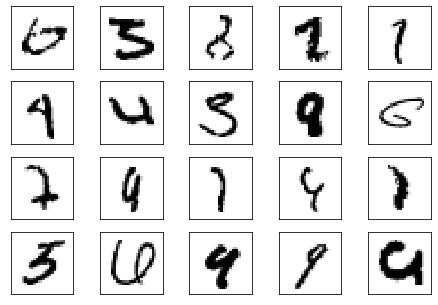

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

## 8.3.4 연산 정밀도와 비트 줄이기
- 수치 정밀도를 반정밀도(16비트)로 낮춰 계산하여 배정밀도(64비트)일 때와 정확도를 비교해본다.

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9938
caluculate accuracy (float16) ... 
0.9938


# 요약 정리 최종

- 수많은 문제에서 신경망을 더 깊게 하여 성능을 개선할 수 있다.
- ILSVRC에서는 2012년 이후 딥러닝 기반 기법이 상위권을 독점하고 있으며, 그 깊이가 깊어지는 추세이다. -> VGG, GoogleLeNet, ResNet
- GPU와 분산 학습, 비트 정밀도 감소 등으로 딥러닝을 고속화 할 수 있다.
- 딥러닝은 사물 인식, 사물 검출, 분할에 활용된다.
- 딥러닝의 응용 분야로는 사진의 캡션 생성(with 자연어처리), 이미지 생성(GAN), 강화학습 등이 있다.